In [1]:
from collections import OrderedDict
from itertools import chain
from typing import List, Tuple

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

# Graph Neural Networks

semi-supervised node classification, i.e. predict the category for each node given a few labels. Each node represents one publication and each edge a citation. The features represent the bag of words of the respective abstract after stemming and stop word removal. These papers are classified into one of the following seven classes:
- Case Based
- Genetic Algorithms
- Neural Networks
- Probabilistic Methods
- Reinforcement Learning
- Rule Learning
- Theory

In [3]:
import torch
from torch import nn
from torch import sparse as sp
from torch.nn import functional as F

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
use_cuda = torch.cuda.is_available() # = False

## Load data

* `N` = number of publications (nodes in the graph)
* `D` = number of features (bag of words one hot representation)
<!--* `C` = number of categories-->
* The graph is stored as a _sparse torch tensor_ `A` (shape `[N, N]`).
* The (binary) Features are stored in a _feature tensor_ `X` (shape `[N, D]`).
* The labels are stored in a _vector_ `y` (shape `[N]`).

In [6]:
X = torch.load('./X.pt')
N, D = X.shape

A_indices = torch.load('./A_indices.pt')
A = torch.sparse.FloatTensor(A_indices, torch.ones_like(A_indices[0]).float(), (N, N)).coalesce()
del A_indices

labels = torch.load('./labels.pt')
C = labels.max().item() + 1

if use_cuda:
    A, X, labels = A.cuda(), X.cuda(), labels.cuda()

A, X, labels, N, D, C

<ipython-input-6-fd69bc5641cc>:5: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  A = torch.sparse.FloatTensor(A_indices, torch.ones_like(A_indices[0]).float(), (N, N)).coalesce()


(tensor(indices=tensor([[   0,    0,    0,  ..., 2808, 2809, 2809],
                        [   0, 1579, 1581,  ..., 2808, 1399, 2809]]),
        values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
        size=(2810, 2810), nnz=18772, layout=torch.sparse_coo),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0, 1, 1,  ..., 4, 6, 3]),
 2810,
 2879,
 7)

## Graph Convolutional Network

- The update scheme is: $𝐻^{(𝑙+1)}=\sigma\left(𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}} 𝐻^{(𝑙)} 𝑊{(𝑙)}\right)$

- ReLU for the activation function, but in the last layer no activation at all.
- $𝐻^{(0)}$ denotes the node features.
- First defining the message passing / graph convolution module and then using this building block for a GCN.

#### Graph Convolution Layer / Message Passing

- The normalized adjacency matrix is $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$.
- What we are implementing is:
$Z^{(𝑙+1)}=\hat{A} 𝐻^{(𝑙)} 𝑊{(𝑙)}$

In [8]:
class GraphConvolution(nn.Module):
    """
    in_channels: int, Dimensionality of input channels/features.
    out_channels: int, Dimensionality of output channels/features.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self._linear = nn.Linear(in_channels, out_channels, bias=False)

    def forward(self, arguments: Tuple[torch.tensor, torch.sparse.FloatTensor]) -> torch.tensor:
        """
        arguments: Tuple[torch.tensor, torch.sparse.FloatTensor]
          Tuple of feature matrix `X` and normalized adjacency matrix `A_hat`
        X: torch.tensor
          The result of the message passing step
        """
        X, A_hat = arguments
        X = A_hat @ self._linear(X)
        return X

#### Graph Convolution Network
- This task to two-fold: Calculating `A_hat` in `_normalize(...)` and (2) connecting the building blocks in `forward(...)`.

In [9]:
class GCN(nn.Module):
    """
    n_features: int, Dimensionality of input features.
    n_classes: int, Number of classes for the semi-supervised node classification.
    hidden_dimensions: List[int], Internal number of features. `len(hidden_dimensions)` defines the number of hidden representations.
    activation: nn.Module, The activation for each layer but the last.
    dropout: The dropout probability.
    """

    def __init__(self,
                 n_features: int,
                 n_classes: int,
                 hidden_dimensions: List[int] = [64],
                 activation: nn.Module = nn.ReLU(),
                 dropout: float = 0.5):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.hidden_dimensions = hidden_dimensions
        self.propagate = nn.ModuleList(
            # Input and hidden layers
            [
                nn.Sequential(OrderedDict([
                    (f'gcn_{idx}', GraphConvolution(in_channels=in_channels,
                                                    out_channels=out_channels)),
                    (f'activation_{idx}', activation),
                    (f'dropout_{idx}', nn.Dropout(p=dropout))
                ]))
                for idx, (in_channels, out_channels)
                in enumerate(zip([n_features] + hidden_dimensions[:-1], hidden_dimensions))
            ]
            # Output and hidden layer
            + [
                nn.Sequential(OrderedDict([
                    (f'gcn_{len(hidden_dimensions)}', GraphConvolution(in_channels=hidden_dimensions[-1],
                                                        out_channels=n_classes))
                ]))
            ]
        )


    def _normalize(self, A: torch.sparse.FloatTensor) -> torch.tensor:
        """
        For calculating $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$.
        A: torch.sparse.FloatTensor, Sparse adjacency matrix with added self-loops.
        A_hat: torch.sparse.FloatTensor, Normalized message passing matrix
        """
        row, col = A._indices()
        edge_weight = A._values()
        deg = (A @ torch.ones(A.shape[0], 1, device=A.device)).squeeze()
        deg_inv_sqrt = deg.pow(-0.5)
        normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        A_hat = torch.sparse.FloatTensor(A._indices(), normalized_edge_weight, A.shape)
        return A_hat

    def forward(self, X: torch.Tensor, A: torch.sparse.FloatTensor) -> torch.tensor:
        """
        X: torch.tensor, Feature matrix `X`
        A: torch.sparse.FloatTensor, adjacency matrix `A` (with self-loops)

        X: torch.tensor, The result of the last message passing step (i.e. the logits)
        """
        ##########################################################
        # YOUR CODE HERE
        A_hat = self._normalize(A)
        for layer in self.propagate:
            X = layer((X, A_hat))
        ##########################################################
        return X

In [10]:
three_layer_gcn = GCN(n_features=D, n_classes=C, hidden_dimensions=[64, 64])
if use_cuda:
    three_layer_gcn = three_layer_gcn.cuda()

three_layer_gcn

GCN(
  (propagate): ModuleList(
    (0): Sequential(
      (gcn_0): GraphConvolution(
        (_linear): Linear(in_features=2879, out_features=64, bias=False)
      )
      (activation_0): ReLU()
      (dropout_0): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (gcn_1): GraphConvolution(
        (_linear): Linear(in_features=64, out_features=64, bias=False)
      )
      (activation_1): ReLU()
      (dropout_1): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (gcn_2): GraphConvolution(
        (_linear): Linear(in_features=64, out_features=7, bias=False)
      )
    )
  )
)

### Training
The `split` method for obtaining a train/validation/test-split.
- Calculating the train and validation loss
- Performing the backward step.

In [11]:
def split(labels: np.ndarray,
          train_size: float = 0.025,
          val_size: float = 0.025,
          test_size: float = 0.95,
          random_state: int = 42) -> List[np.ndarray]:
    """Split the arrays or matrices into random train, validation and test subsets.
    labels: The class labels
    train_size: Proportion of the dataset included in the train split.
    val_size: Proportion of the dataset included in the validation split.
    test_size: Proportion of the dataset included in the test split.
    random_state: Random_state is the seed used by the random number generator;

    split_train: The indices of the training nodes
    split_val: The indices of the validation nodes
    split_test The indices of the test nodes
    """
    idx = np.arange(labels.shape[0])
    idx_train_and_val, idx_test = train_test_split(idx,
                                                   random_state=random_state,
                                                   train_size=(train_size + val_size),
                                                   test_size=test_size,
                                                   stratify=labels)

    idx_train, idx_val = train_test_split(idx_train_and_val,
                                          random_state=random_state,
                                          train_size=(train_size / (train_size + val_size)),
                                          test_size=(val_size / (train_size + val_size)),
                                          stratify=labels[idx_train_and_val])

    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = split(labels.cpu().numpy())

In [12]:
def train(model: nn.Module,
          X: torch.Tensor,
          A: torch.sparse.FloatTensor,
          labels: torch.Tensor,
          idx_train: np.ndarray,
          idx_val: np.ndarray,
          lr: float = 1e-3,
          weight_decay: float = 5e-4,
          patience: int = 50,
          max_epochs: int = 300,
          display_step: int = 10):
    """
    Train a model using standard training.
    X: Dense attribute matrix.
    A: Sparse adjacency matrix.
    idx_train: Indices of the training nodes.
    idx_val: Indices of the validation nodes.
    patience: The number of epochs to wait for the validation loss to improve before stopping early.

    trace_train: A list of values of the train loss during training.
    trace_val: A list of values of the validation loss during training.
    """
    trace_train = []
    trace_val = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_loss = np.inf
    for it in tqdm(range(max_epochs), desc='Training...'):
        logits = model(X, A)

        loss_train = F.cross_entropy(logits[idx_train], labels[idx_train])
        loss_val = F.cross_entropy(logits[idx_val], labels[idx_val])

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        trace_train.append(loss_train.detach().item())
        trace_val.append(loss_val.detach().item())

        if loss_val < best_loss:
            best_loss = loss_val
            best_epoch = it
            best_state = {key: value.cpu() for key, value in model.state_dict().items()}
        else:
            if it >= best_epoch + patience:
                break

        if display_step > 0 and it % display_step == 0:
            print(f'Epoch {it:4}: loss_train: {loss_train.item():.5f}, loss_val: {loss_val.item():.5f} ')

    # restore the best validation state
    model.load_state_dict(best_state)
    return trace_train, trace_val

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch    0: loss_train: 1.94579, loss_val: 1.94565 
Epoch   10: loss_train: 1.77347, loss_val: 1.82798 
Epoch   20: loss_train: 1.46261, loss_val: 1.62133 
Epoch   30: loss_train: 1.00571, loss_val: 1.36089 
Epoch   40: loss_train: 0.69302, loss_val: 1.11327 
Epoch   50: loss_train: 0.45070, loss_val: 0.93009 
Epoch   60: loss_train: 0.26322, loss_val: 0.78994 
Epoch   70: loss_train: 0.21597, loss_val: 0.77197 
Epoch   80: loss_train: 0.15232, loss_val: 0.68289 
Epoch   90: loss_train: 0.11278, loss_val: 0.68732 
Epoch  100: loss_train: 0.08929, loss_val: 0.73632 
Epoch  110: loss_train: 0.05560, loss_val: 0.71808 
Epoch  120: loss_train: 0.05793, loss_val: 0.62133 
Epoch  130: loss_train: 0.04794, loss_val: 0.62916 
Epoch  140: loss_train: 0.04648, loss_val: 0.82189 
Epoch  150: loss_train: 0.02427, loss_val: 0.78698 
Epoch  160: loss_train: 0.03387, loss_val: 0.59385 
Epoch  170: loss_train: 0.02223, loss_val: 0.69412 
Epoch  180: loss_train: 0.02973, loss_val: 0.68559 
Epoch  190: 

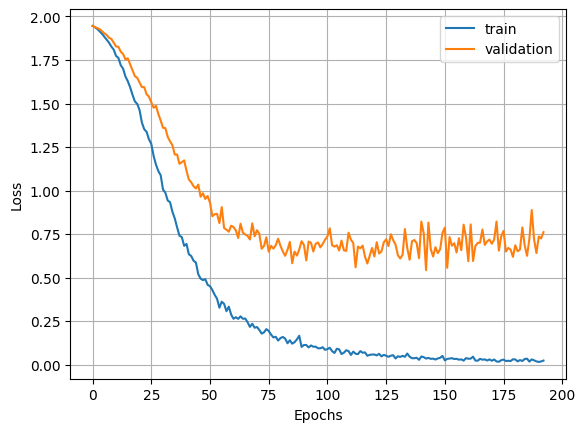

In [13]:
trace_train, trace_val = train(three_layer_gcn, X, A, labels, idx_train, idx_val)

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## Personalized Propagation of Neural Predictions

GCN comes with several limitations, some of them are targeted via (Approximate) Personalized Propagation of Neural Predictions (A)PPNP.

- Using the iterative approach to approximate the personalized page rank:
$$𝐻^{(𝑙+1)}= (1−\alpha) \delta_{\text{dropout}} \hat{A} 𝐻^{(𝑙)} + \alpha 𝐻^{(0)}$$
- $\alpha$ denotes the restart/teleport probability
- $𝐻^{(0)}$ the result of a feed forward neural network on the input features $𝐻^{(0)}=f_{\theta}(X)$.
- Dropout is applied to the approximate propagation step
- In each step, a randomly drawn dropout mask $\delta_{\text{dropout}}$ is multiplied with the normalized adjacency matrix $\hat{A} = 𝐷^{−\frac{1}{2}} 𝐴 𝐷^{−\frac{1}{2}}$.

### Sparse Dropout

- simply applying dropout to the values of the sparse matrix and then constructing the sparse matrix again (`torch.sparse.FloatTensor(...)`).

In [14]:
def sparse_dropout(A: torch.sparse.FloatTensor, p: float, training: bool) -> torch.sparse.FloatTensor:
    drop_val = F.dropout(A._values(), p, training)
    A = torch.sparse.FloatTensor(A._indices(), drop_val, A.shape)
    return A

### Approximate Personalized Pagerank

- the power iteration for approximating the personalized page rank

In [15]:
class PowerIterationPageRank(nn.Module):
    """
    Power itertaion module for propagating the labels.

    alpha: The teleport probability.
    n_propagation: The number of iterations for approximating the personalized page rank.
    """

    def __init__(self,
                 dropout: float = 0.5,
                 alpha: float = 0.15,
                 n_propagation: int = 5):
        super().__init__()
        self.dropout = dropout
        self.alpha = alpha
        self.n_propagation = n_propagation

    def forward(self, logits: torch.Tensor, A_hat: torch.sparse.FloatTensor) -> torch.tensor:
        """
        A_hat: The normalized adjacency matrix `A_hat`.

        logits: The propagated/smoothed logits.
        """
        local_logits = logits
        for i in range(self.n_propagation):
            A_drop = sparse_dropout(A_hat, self.dropout, self.training)
            logits = (1 - self.alpha) * sp.mm(A_drop, logits) + self.alpha * local_logits
        return logits

### Approximate Personalized Propagation of Neural Predictions

- Putting it all together

In [16]:
class APPNP(GCN):
    """
    Approximate Personalized Propagation of Neural Predictions
    """

    def __init__(self,
                 n_features: int,
                 n_classes: int,
                 hidden_dimensions: List[int] = [64],
                 activation: nn.Module = nn.ReLU(),
                 dropout: float = 0.5,
                 alpha: float = 0.1,
                 n_propagation: int = 5):
        super().__init__(n_features, n_classes)
        self.n_features = n_features
        self.n_classes = n_classes
        self.hidden_dimensions = hidden_dimensions
        self.dropout = dropout
        self.transform_features = (
            # Input dropout
            nn.Sequential(OrderedDict([
                (f'dropout_{0}', nn.Dropout(p=self.dropout))
            ]
            # Hidden layers
            + list(chain(*[
                [(f'linear_{idx}', nn.Linear(in_features=in_features, out_features=out_features)),
                 (f'activation_{idx}', activation)]
                for idx, (in_features, out_features)
                in enumerate(zip([n_features] + hidden_dimensions[:-1], hidden_dimensions))
            ]))
            # Last layer
            + [
                (f'linear_{len(hidden_dimensions)}', nn.Linear(in_features=hidden_dimensions[-1],
                                                            out_features=n_classes)),
                (f'dropout_{len(hidden_dimensions)}', nn.Dropout(p=self.dropout)),
            ]))
        )
        self.propagate = PowerIterationPageRank(dropout=dropout,
                                                 alpha=alpha,
                                                 n_propagation=n_propagation)

    def forward(self, X: torch.Tensor, A: torch.sparse.FloatTensor) -> torch.tensor:
        A_hat = self._normalize(A)
        logits = self.transform_features(X)
        logits = self.propagate(logits, A_hat)
        return logits

In [17]:
three_layer_appnp = APPNP(n_features=D, n_classes=C, hidden_dimensions=[64, 64])
if use_cuda:
    three_layer_appnp = three_layer_appnp.cuda()

three_layer_appnp

APPNP(
  (propagate): PowerIterationPageRank()
  (transform_features): Sequential(
    (dropout_0): Dropout(p=0.5, inplace=False)
    (linear_0): Linear(in_features=2879, out_features=64, bias=True)
    (activation_0): ReLU()
    (linear_1): Linear(in_features=64, out_features=64, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=64, out_features=7, bias=True)
    (dropout_2): Dropout(p=0.5, inplace=False)
  )
)

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch    0: loss_train: 1.93165, loss_val: 1.94540 
Epoch   10: loss_train: 1.82641, loss_val: 1.89381 
Epoch   20: loss_train: 1.61252, loss_val: 1.78156 
Epoch   30: loss_train: 1.41205, loss_val: 1.53858 
Epoch   40: loss_train: 1.08700, loss_val: 1.39551 
Epoch   50: loss_train: 0.93472, loss_val: 1.18571 
Epoch   60: loss_train: 0.70940, loss_val: 1.00764 
Epoch   70: loss_train: 0.55776, loss_val: 0.97241 
Epoch   80: loss_train: 0.46882, loss_val: 0.87339 
Epoch   90: loss_train: 0.41508, loss_val: 0.85015 
Epoch  100: loss_train: 0.36746, loss_val: 0.82720 
Epoch  110: loss_train: 0.21120, loss_val: 0.71450 
Epoch  120: loss_train: 0.24047, loss_val: 0.87736 
Epoch  130: loss_train: 0.24082, loss_val: 0.75870 
Epoch  140: loss_train: 0.24874, loss_val: 0.74319 
Epoch  150: loss_train: 0.24039, loss_val: 0.80070 


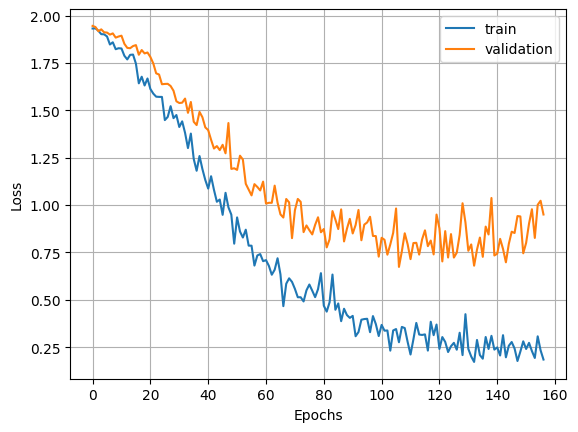

In [18]:
trace_train, trace_val = train(three_layer_appnp, X, A, labels, idx_train, idx_val)

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

## Oversmoothing
- Limiting the number of message passing steps for a vanilla GCN to prevent oversmoothing
- plotting the test accuracy over the number of propagation steps

In [19]:
def calc_accuracy(logits: torch.Tensor, labels: torch.Tensor, idx_test: np.ndarray) -> float:
    accuracy = (torch.argmax(logits, dim=-1) == labels)[idx_test].float().mean()
    return accuracy

## Comparing GCN and APPNP

- plotting the accuracies over the numer of propagation steps

In [20]:
n_hidden_dimensions = 64
n_propagations = [1,2,3,4,5,10]

test_accuracy_gcn = []
for n_propagation in n_propagations:
    model = GCN(n_features=D, n_classes=C, hidden_dimensions=n_propagation*[n_hidden_dimensions])
    if use_cuda:
        model = model.cuda()
    train(model, X, A, labels, idx_train, idx_val, display_step=-1)

    model.eval()
    logits = model(X, A)
    accuracy = calc_accuracy(logits, labels, idx_test).cpu().numpy()

    test_accuracy_gcn.append(accuracy)

test_accuracy_appnp = []
for n_propagation in n_propagations:
    model = APPNP(n_features=D, n_classes=C, n_propagation=n_propagation)
    if use_cuda:
        model = model.cuda()
    train(model, X, A, labels, idx_train, idx_val, display_step=-1)

    model.eval()
    logits = model(X, A)
    accuracy = calc_accuracy(logits, labels, idx_test).cpu().numpy()

    test_accuracy_appnp.append(accuracy)

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

Training...:   0%|          | 0/300 [00:00<?, ?it/s]

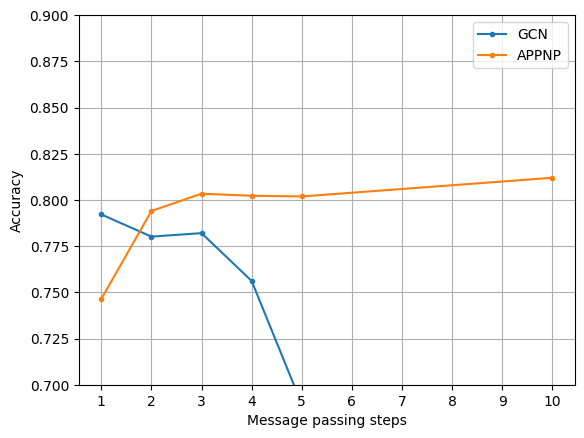

In [21]:
plt.plot(n_propagations, test_accuracy_gcn, label='GCN', marker='.')
plt.plot(n_propagations, test_accuracy_appnp, label='APPNP', marker='.')
plt.xlabel('Message passing steps')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.legend()
plt.grid(True)